In [219]:
using LogicCircuits

function l_revision(circuit)
    VERBOSE = false
    circuit = PlainLogicCircuit(circuit)
    root = circuit
    current = circuit
    parent = circuit
    visited = Any[]
    parents = Any[]
    stopping = false
    while !stopping
        if typeof(current) == Plain⋁Node
            for i = 1:length(current.children)
                if !(current.children[i] in visited)
                    push!(parents,current)
                    current = current.children[i]
                    push!(visited,current)
                    break
                end
                if i == length(current.children)
                    if current == root
                        stopping = true
                    end
                    for i = 1:length(visited)
                        if current == visited[i]
                            current = parents[i]
                            break
                        end
                    end
                end 
            end
        elseif typeof(current) == Plain⋀Node
            if !(current.children[1] in visited)
                push!(parents,current)
                current = current.children[1]
                push!(visited,current)
            elseif !(current.children[2] in visited)
                push!(parents,current)
                current = current.children[2]
                push!(visited,current)
            else
                for i = 1:length(visited)
                    if current == visited[i]
                        current = parents[i]
                        break
                    end
                end
            end
        else 
            if typeof(current) == PlainLiteralNode
                VERBOSE && println("L",current.literal,"")
                piece = PlainLogicCircuit(-current.literal)
                circuit = replace_node(circuit,current,piece)
            elseif typeof(current) == PlainTrueNode
                VERBOSE && println("T")
            elseif typeof(current) == PlainFalseNode
                VERBOSE && println("F")                
                #piece = PlainLogicCircuit(PlainTrueNode)
                #circuit3 = replace_node(circuit3,current,piece)            
            end
            for i = 1:length(visited)
                if current == visited[i]
                    current = parents[i]
                    break
                end
            end
        end
    end
    return circuit
end

l_revision (generic function with 1 method)

L1
L2
T
L-2
L-3
L-1


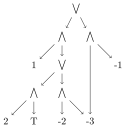

In [218]:
sun, rain, rainbow = pos_literals(LogicCircuit, 3)
circuit = (rainbow & sun & rain) | (-rainbow); # rainbow implies sun and rain
manager = SddMgr(7, :balanced)
#:rightlinear, :leftlinear, :random, :balanced
circuit2 = compile(manager, circuit);
plot(circuit2)

In [ ]:
plot(l_revision(circuit2))